In [11]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
import torch

from langgraph.prebuilt import ToolNode,tools_condition
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader


from langchain_text_splitters import RecursiveCharacterTextSplitter


from langchain_core.tools import tool #for the custom chatbot

from langgraph.types import interrupt, Command


In [12]:
import os
import streamlit as st
from dotenv import load_dotenv

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

# LLM loader (cached)
@st.cache_resource
def get_llm():
    llm_endpoint = HuggingFaceEndpoint(
        repo_id="meta-llama/Llama-3.2-3B-Instruct",
        temperature=0.01,
        max_new_tokens=512,
        huggingfacehub_api_token=HF_TOKEN,
        task="text-generation",
    )
    return ChatHuggingFace(llm=llm_endpoint)

llm = get_llm()

prompt = HumanMessage(content="hello")

response = llm.invoke([prompt])
print(response.content)


Hello! How can I assist you today?


In [13]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


In [14]:
def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}

    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}

In [15]:
#builing the graph START-> chat -> End
from langgraph.checkpoint.memory import MemorySaver

builder=StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

#checkpointer is required for interrupts
checkpointer=MemorySaver()

#compile the app
app=builder.compile(checkpointer=checkpointer)

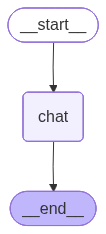

In [16]:
app

In [32]:
# Create a new thread id for this conversation
config = {"configurable": {"thread_id": '1234'}}

# ---- STEP 1: user asks a question ----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)

In [33]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='0c034fe2-5283-42f5-9fe9-265e328e3fb0'),
  AIMessage(content='Gradient Descent is a simple algorithm used to optimize (or improve) a mathematical function. Here\'s how it works:\n\n**Imagine you\'re trying to find the best way to climb a hill**\n\n1. You start at the bottom of the hill (a random point).\n2. You look at the slope of the hill at your current position (this is called the "gradient").\n3. If the slope is steep (negative), you move up the hill (because you want to go in the opposite direction of the slope).\n4. If the slope is shallow (positive), you move down the hill (because you want to go in the same direction as the slope).\n5. You keep moving up or down the hill until the slope becomes very shallow (almost zero).\n6. At this point, you\'ve reached the top of the hill (or the "minimum" of the function).\n\n**In Gradient Descent, the "hill"

In [34]:
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? yes/no'}

In [35]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (y/n): ")

In [36]:
# Resume the graph with the approval decision
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)

In [37]:
print(final_result["messages"][-1].content)

Here's a simple explanation:

**Gradient Descent is a way to find the best answer**

Imagine you have a big box of different colored balls, and you want to find the ball that is closest to a target ball.

1. You start by picking a ball at random.
2. You look at how close the ball is to the target ball (this is called the "distance").
3. If the ball is too far away, you move it a little bit closer to the target ball.
4. If the ball is already close, you move it a tiny bit closer.
5. You keep doing this until the ball is right next to the target ball.

Gradient Descent is like this process, but instead of balls, it's used to find the best answer to a math problem. It starts with a guess, looks at how good the guess is, and then makes a tiny adjustment to get closer to the best answer.

That's Gradient Descent in a nutshell!
